# Nonadiabatic Dynamics with Spin-boson and FMO-like Hamiltonians


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Model definitions](#2)
   
3. [Choose the Model](#3)

4. [Choose the Nonadiabatic Dynamics Methodology](#4)

5. [Choose the initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)



## A. Learning objectives

- to setup NA-MD calculations for a multi-dimensional Hamiltonian problem (many nuclear DOFs) of spin-boson/FMO type
- to learn about the discretization of various bath types
- to prepare initial nuclear condition as taken from the normal distribution
- to initialize electronic states as diabatic ones
- to be able to plot the key results of NA-MD simulations


## B. Use cases

- Wigner sampling


## C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)        
  - `models`     
     - `GLVC`
       - [`GLVC`](#GLVC-1) | [`also here`](#GLVC-2)
       - [`get_GLVC_set1`](#get_GLVC_set1-1)
       - [`get_GLVC_set2`](#get_GLVC_set2-1)
       - [`get_GLVC_set3`](#get_GLVC_set3-1)
       - [`get_GLVC_set4`](#get_GLVC_set4-1)
       - [`get_GLVC_set5`](#get_GLVC_set5-1)
       - [`get_GLVC_set6`](#get_GLVC_set6-1)
       
       

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import models
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import fssh, fssh2, fssh3, gfsh

import libra_py.models.GLVC as GLVC


warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]


<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWar

## 2. Model definitions
<a name="2"></a>[Back to TOC](#TOC)

<a name="GLVC-1"></a>
In all cases, we will be using the GLVC (generalize vibronic coupling models) defined in `libra_py.models.GLVC` module.

The Hamiltonian of this kind is a one for N electronic levels and for F nuclear degrees of freedom as:

$$H = H_s + H_b + H_{sb,1}$$

System Hamiltonian in the diabatic basis:

$$H_s = \left( \begin{matrix}
E_0 & V_{01} & \cdots \\
V_{10} & E_1 & \cdots \\
\vdots & \vdots & \ddots \\
\end{matrix} \right)$$

Bath Hamiltonian:
    
$$H_b  = \sum_{n=0}^{N-1} \sum_{f=0}^{F-1} \{ |n> \frac{p_f^2}{2 m_f} + \frac{1}{2} m_f \omega_{n,f}^2 q_f^2 ) <n| \} $$

the kinetic energy term present in this expression is just given for the completeness - it is not included in the Hamiltonian calculation function here. 

The frequencies $\omega_{n,f} $may in general be different for all states

$$H_{sb,1} = \sum_{n=0}^{N-1} s_n \sum_{f=0}^{F-1} \{ |n> c_{n,f} q_f <n| \} $$

the diagonal linear coupling terms, $c_{n,f}$, couplings may in general be different for all states

The $s_n$ is the scaling factor with which the sum over all modes in $H_{sb,1}$ enters the total Hamiltonian for the given state $n$

Summary of the terms:

* $N$ - number of electronic states - corresponds to `params["nstates"]` below

* $F$ - number of nuclear modes (bath oscillators) - corresponds to `params["num_osc"]` below

*  $H_s$ - system Hamiltonian (constants) - corresponds to `params["Ham"]` below

*  $m_f$ - mass of the nuclear DOF f- corresponds to f-th element of `params["mass"]` below

*  $\omega_{n, f}$ - frequency of the f-th mode on n-th electronic state - corresponds to {n,f}-th element of `params["omega"]` below 

*  $c_{n, f}$ - linear coupling of the f-th mode to n-th electronic state - corresponds to {n,f}-th element of `params["coupl"]` below 

*  $s_n$ - scaling factor for the n-th state - corresponds to n-th element of `params["coupling_scaling"]` below 


The couplings and frequencies can be defined manually or derived from the known spectral densities (controlled by the parameter `params["spectral_density"]` below):

- `params["spectral_density"] = 0` we have user-defined couplings and frequencies

- `params["spectral_density"] = 1` we have *Debye* spectral density:

$$J(w) = \frac{\lambda}{2} \frac{\omega \omega_c}{\omega^2 + \Omega^2}$$

- `params["spectral_density"] = 2` we have *Ohmic* spectral density:

$$J(w) = \frac{\pi \hbar \xi}{2}  \omega exp\left(-\frac{\omega}{\Omega} \right)$$

Debye and Ohmic bath discretizations are according to:

    Wu, D.; Hu, Z.; Li, J.; Sun, X. Forecasting Nonadiabatic Dynamics Using Hybrid Convolutional 
    Neural Network/Long Short-Term Memory Network. The Journal of Chemical Physics 2021, 155 (22), 224104. https://doi.org/10.1063/5.0073689.
    
as:

1. Debye:
$$ \omega_f = \Omega \tan \left( \frac{\pi}{2} (1 - \frac{f+1}{F+1}) \right) \forall f = 0,..., F-1 $$

$$ c_f = - \omega_f \sqrt { \frac{2 \lambda}{F+1} } \forall f = 0, ..., F-1$$

2. Ohmic:

$$ \omega_f = -\Omega \log \left( 1 - \frac{f+1}{F+1} \right) \forall f = 0,..., F-1 $$

$$ c_f = - \omega_f \sqrt { \frac{2 \lambda}{F+1} } \forall f = 0, ..., F-1$$


In these definitions:

- $\lambda$ - reorganization energy, defined in `params["lambda"]`

- $\Omega$ - characteristic frequency of the bath, defined in `params["Omega"]`

Also, temperature of the bath is given by:  `params["beta"]` which is $\frac{1}{k_B T}$


Finally, in all these models, the energies, couplings, and other parameters are given in units of $k_B T$ for T = 300 K.

Note, that typical spin-boson (2-level) Hamiltonian is given with $s_0 = 1$ and $s_1 = -1$

For the higher-level Hamiltonians (e.g. FMO models), the $s_i = 1 \forall i = 0, 1, ...$

While the Hamiltonian itself is defined in `libra_py.models.GLVC.py` module, the definition of the parameters is the key part of defining the appropriate model.

Here is a manual definition of the function to set up the parameters:

In [2]:
def custom_GLVC_set(E1, E2, V01, V02, V12):
    """
    3-state spin-boson model: the bath parameters are from:

    Bondarenko, A. S.; Tempelaar, R. Overcoming Positivity Violations for Density Matrices in Surface Hopping. 
    The Journal of Chemical Physics 2023, 158 (5), 054117. https://doi.org/10.1063/5.0135456.

    but the number of discretized bath modes is reduced to 25

    and the system parameters are adjusted

    Args:
        E1, E2, V01, V02, V12: energies and couplings in terms of kT


    Returns:
        dictionary: params, will contain the parameters:

        * **nstates** (int): the number of electronic states

        * **num_osc** (int): the number of oscillators per electronic state

        * **spectral_density** (int): type of spectral density calculation - Debye

        * **Omega** (double): characteristic frequency of bath [units: Ha]

        * **lambda** (double): bath reorganization energy [units: Ha]

        * **omega** (list of doubles): frequencies of the discretized spectral density [ units: Ha ]

        * **coupl** (list of doubles): electron-nuclear couplings, same for all states, different for each oscillator [ units: Ha ]

        * **mass** (list of doubles): masses of nuclear DOFs [ units: a.u. ]

        * **coupling_scaling** (list of `nstates` doubles): the scaling applied to the overall linear coupling terms for each state [ unitS: N/A ]

        * **beta** (double): inverse temperature, 1/(kB*T) [ units: Ha^-1 ]

        * **Ham** (list of `nstates` lists of `nstates` doubles): diabatic state energies and couplings [ units: Ha ]


    """

    s = 208.5 * units.inv_cm2Ha # thermal energy at 300 K

    params = {}
    nosc = 25
    params["nstates"] = 3
    params["num_osc"] = nosc  # not described in the paper, but let's assume it is the same as in their 2-state model
    params["spectral_density"] = 1  # Debye
    params["model"] = 0
    params["model0"] = 0

    L, Om, T = 0.01, 0.1, 1.0

    E1 = E1 * s
    E2 = E2 * s
    V01 = V01 * s
    V02 = V02 * s
    V12 = V12 * s

    params["Omega"] = Om * s
    params["lambda"] = L * s
    params["beta"] = 1.0/(T*s)
    OM, CO, mass = GLVC.gen_bath_params(params)
    params["omega"] = [ list(OM), list(OM), list(OM) ]
    params["coupl"] = [ list(CO), list(CO), list(CO) ]
    #params["mass"] = list(mass)
    params["mass"] = [1.0 for _ in range(nosc)]

    params["Ham"] = [ [0.0,  V01, V02], 
                      [ V01, E1,  V12],
                      [ V02, V12, E2 ] ]
    params["coupling_scaling"] = [1.0, -1.0, -1.0]

    return params


One can also define the parameters from the published papers:

3-state FMO model:

     Runeson, J. E.; Manolopoulos, D. E. J. Chem. Phys. 159, 094115, 2023
<a name="get_GLVC_set1-1"></a>

In [3]:
model_params1 = GLVC.get_GLVC_set1(); model_params1.update({"model":0, "model0":0 })  # 3-states FMO

2-state spin-boson model

    Tempelaar, R.; Reichman, D. R. Generalization of Fewest-Switches Surface Hopping for Coherences. 
    The Journal of Chemical Physics 2018, 148 (10), 102309. https://doi.org/10.1063/1.5000843.
<a name="get_GLVC_set2-1"></a>    

In [4]:
model_params20 = GLVC.get_GLVC_set2(0); model_params20.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 2a
model_params21 = GLVC.get_GLVC_set2(1); model_params21.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 2b
model_params22 = GLVC.get_GLVC_set2(2); model_params22.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 2c
model_params23 = GLVC.get_GLVC_set2(3); model_params23.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 2d
model_params24 = GLVC.get_GLVC_set2(4); model_params24.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 3a
model_params25 = GLVC.get_GLVC_set2(5); model_params25.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 3b
model_params26 = GLVC.get_GLVC_set2(6); model_params26.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 3c
model_params27 = GLVC.get_GLVC_set2(7); model_params27.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 4a
model_params28 = GLVC.get_GLVC_set2(8); model_params28.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 4b
model_params29 = GLVC.get_GLVC_set2(9); model_params29.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 5a
model_params210 = GLVC.get_GLVC_set2(10); model_params210.update({"model":0, "model0":0 })  # 2-states spin-boson; Figure 5b

5-state, 5 nuclear DOFS chain of coupled oscillators

    General:
    Wang, L.; Prezhdo, O. V. A Simple Solution to the Trivial Crossing Problem in Surface Hopping. 
    J. Phys. Chem. Lett. 2014, 5 (4), 713–719. https://doi.org/10.1021/jz500025c.

    with N = 5
    Jain, A.; Alguire, E.; Subotnik, J. E. An Efficient, Augmented Surface Hopping Algorithm That 
    Includes Decoherence for Use in Large-Scale Simulations. J. Chem. Theory Comput. 2016, 12 (11), 
    5256–5268. https://doi.org/10.1021/acs.jctc.6b00673.
<a name="get_GLVC_set3-1"></a>    

In [5]:
model_params3 = GLVC.get_GLVC_set3();  model_params3.update({"model":0, "model0":0 })  # 5-states spin-boson model of Jain

3-state, 3 nuclear DOFS chain of coupled oscillators, top row of Figure 4

    By:
    Wang, L.; Prezhdo, O. V. A Simple Solution to the Trivial Crossing Problem in Surface Hopping.
    J. Phys. Chem. Lett. 2014, 5 (4), 713–719. https://doi.org/10.1021/jz500025c.    
<a name="get_GLVC_set4-1"></a>

In [6]:
model_params4 = GLVC.get_GLVC_set4();  model_params4.update({"model":0, "model0":0 })  # 3-states spin-boson model of Wang and Prezhdo

3-state spin-boson model

    Bondarenko, A. S.; Tempelaar, R. Overcoming Positivity Violations for Density Matrices in Surface Hopping. 
    The Journal of Chemical Physics 2023, 158 (5), 054117. https://doi.org/10.1063/5.0135456.
<a name="get_GLVC_set5-1"></a>

In [7]:
model_params50 = GLVC.get_GLVC_set5(0); model_params50.update({"model":0, "model0":0 })  # Figure 1 - homogeneous trimer, adiabatic regime at low T
model_params51 = GLVC.get_GLVC_set5(1); model_params51.update({"model":0, "model0":0 })  # Figure 2 - biased trimer
model_params52 = GLVC.get_GLVC_set5(2); model_params52.update({"model":0, "model0":0 })  # Figure 6 - homogeneous trimer, adiabatic regime at low T, larger reorg. energy
# SI from Tempelaar
model_params53 = GLVC.get_GLVC_set5(3); model_params53.update({"model":0, "model0":0 })  # top figure first column on page S4 of SI
model_params54 = GLVC.get_GLVC_set5(4); model_params54.update({"model":0, "model0":0 })  # top figure third column on page S4 of SI
model_params55 = GLVC.get_GLVC_set5(5); model_params55.update({"model":0, "model0":0 })  # bottom figure first column on page S4 of SI
model_params56 = GLVC.get_GLVC_set5(6); model_params56.update({"model":0, "model0":0 })  # bottom figure third column on page S4 of SI

2-state spin-boson model

    Mannouch, J. R.; Richardson, J. O. A Mapping Approach to Surface Hopping. The Journal of Chemical Physics 2023, 158 (10), 104111. https://doi.org/10.1063/5.0139734.
<a name="get_GLVC_set6-1"></a>

In [8]:
model_params60 = GLVC.get_GLVC_set6(0, 1.0); model_params60.update({"model":0, "model0":0 })  # Figure 10a
model_params61 = GLVC.get_GLVC_set6(1, 1.0); model_params61.update({"model":0, "model0":0 })  # Figure 10b
model_params62 = GLVC.get_GLVC_set6(2, 1.0); model_params62.update({"model":0, "model0":0 })  # Figure 10c

<a name="GLVC-2"></a>

In [9]:
def compute_model(q, params, full_id):
    model = params["model"]
    res = None

    if model==0:
        res = GLVC.GLVC(q, params, full_id)
    else:
        pass

    return res


def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

## 3. Choose the Model
<a name="3"></a>[Back to TOC](#TOC)

Below, choose the model either via the manually-defined function that generates the parameters or uncomment one of the lines with the pre-defined models defined above

In [10]:
############################################################
##### 1. Choose the model
############################################################

#======== Manual definition of the 3-level =========
# in units of kB * T with T = 300 K
E1 = 0.5 
E2 = 1.0
V01 = 0.0
V12 = 0.0
V02 = 0.5

model_params = custom_GLVC_set(E1, E2, V01, V02, V12)

#======== Or pick one of the pre-defined parameters =========
#model_params = model_params1
#model_params = model_params20
#model_params = model_params21
#model_params = model_params22
#model_params = model_params23
#model_params = model_params24
#model_params = model_params25
#model_params = model_params26
#model_params = model_params27
#model_params = model_params28
#model_params = model_params29
#model_params = model_params210
#model_params = model_params3
#model_params = model_params4
#model_params = model_params50
#model_params = model_params51
#model_params = model_params52
#model_params = model_params53
#model_params = model_params54
#model_params = model_params55
#model_params = model_params56
#model_params = model_params60
#model_params = model_params61
#model_params = model_params62

#== For convenience, define the global variable : the number of states in the picked model ========
NSTATES = model_params["nstates"]

## 4. Choose the Nonadiabatic Methodology
<a name="4"></a>[Back to TOC](#TOC)

In [11]:
############################################################
##### 2. Choose the Nonadiabatic Dynamics Methodology 
############################################################

dyn_general = { "nsteps":1000, "ntraj":25, "nstates":NSTATES,
                "dt":41.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "states", "se_pop_adi", "se_pop_dia", "sh_pop_adi", "sh_pop_dia"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }
fssh.load(dyn_general) # FSSH

# To test the new decoherence method based on Gu-Franco formula, uncommend this line:
#dyn_general.update({"reorg_energy": 0.01 * 208.5 * units.inv_cm2Ha, "Temperature":300.0, "decoherence_times_type":5, "decoherence_algo":9  })

## 5. Choose the initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

### 5.1. Nuclear:

The nuclear coordinates are chosen from the classical (normal) distribution of the corresponding diabatic surfaces:

$$ P(q, p) \approx \prod_{i} { exp \left(-\beta \left(\frac{p_i^2}{2 m_i} + \frac{1}{2} m_i \omega_i^2 q_i^2 \right) \right) } $$

Assuming the form of this distribution to be:

$$ P(q, p) \approx \prod_{i} { exp \left(-\frac{ p_i^2 }{2 \sigma_{p,i}^2} - \frac{ q_i^2 }{2 \sigma_{q,i}^2} \right) } $$

we obtain the relationship between $\sigma_q$ or $\sigma_p$ and other parameters as:

$\sigma_{p,i}^2 = \frac{m_i}{\beta} $ so  $\sigma_{p,i} = \frac{1}{\sqrt { \frac{\beta}{m_i} } } $

$\frac{1}{\sigma_{q,i}^2} = \beta m_i \omega_i^2 $ so  $\sigma_{q,i} = \frac{1}{\omega_i \sqrt{m_i \beta}} $


To initialize the nuclear coordinates and momenta from normal distribution with the width parameters given above, we use     `"init_type":4` and we need to setup the `q_width` and `p_width` parameters

### 5.2. Electronic:

The calculations with the spin-boson-like models are usually started with initially-populated diabatic states.

To start such calculations on selected diabatic state, we simply need to use `"rep":0` and define the state using 
`istate` and/or `istates` variables. 

In [12]:
############################################################
### 3. Choose the initial conditions: Nuclear and Electronic
############################################################

# Nuclear initial conditions 
beta = model_params["beta"]
_nosc = ndof = model_params["num_osc"]
_nst = NSTATES 

# 1/2 * mass * beta * w**2 = 1/2 * (1/sigma_q**2) => sigma_q = 1/(w * sqrt(mass * beta))
# 1/2 * (beta/mass) = 1/2 * (1/sigma_p**2) => sigma_p = 1/(sqrt(beta/mass))
# force_constant = mass * w**2
nucl_params = { "ndof":ndof,
                "q":[0.0 for i in range(ndof)],
                "p":[0.0 for i in range(ndof)],
                "mass":list(model_params["mass"]),
                "force_constant":[ model_params["mass"][i]*model_params["omega"][0][i]**2 for i in range(_nosc) ],
                "q_width":[ 1.0/( math.sqrt(model_params["mass"][i] * beta) * model_params["omega"][0][i]) for i in range(_nosc)  ],
                "p_width":[ 1.0/( math.sqrt(beta/model_params["mass"][i])) for i in range(_nosc)  ],
                "init_type": 4
              }
dt = 0.1/model_params["omega"][0][-1]
print(F"dt = {dt}")

# Electronic initial conditions - start on the second diabatic state (starting from 0 = ground)
##########
istate = 2
##########
istates = [0.0 for i in range(NSTATES)]
istates[istate] = 1.0     
elec_params = {"verbosity":2, "init_dm_type":0,"ndia":NSTATES, "nadi":NSTATES, 
               "rep":0, "init_type":0, "istates":istates, "istate":istate     }

dt = 17401.904183058108


## 6. Run the NA-MD calculations
<a name="6"></a>[Back to TOC](#TOC)

Finally, we are ready to run the calculations:
<a name="generic_recipe-1"></a>

In [13]:
############################################################
### 4. Run the calculations and save the results into the HDF5 files
############################################################

dyn_params = dict(dyn_general)
pref = F"FSSH-E1_{E1}-E2_{E2}-V01_{V01}-V02_{V02}-V12_{V12}"
dyn_params.update({ "prefix":pref, "prefix2":pref })
print(F"Computing {pref}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing FSSH-E1_0.5-E2_1.0-V01_0.0-V02_0.5-V12_0.0
[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2]
Initial adiabatic populations
[0.12, 0.0, 0.88]

======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Initialization type is 0 ========
setting representation 0 coefficient C_2 to 1.0
======= Init

## 7. Plot the results
<a name="7"></a>[Back to TOC](#TOC)
<a name="plot_dynamics-1"></a>

ned! in the input parametersUse the default value 
In cctor: lvl = 1 der_lvl = 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'\nplot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":4,\n                "which_trajectories":[0], "which_dofs":[0], "which_adi_states":list(range(NSTATES)),\n                "which_dia_states":list(range(NSTATES)),\n                "frameon":True, "linewidth":3, "dpi":300,\n                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,\n                "what_to_plot":[ "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham" ],\n                "which_energies":["potential", "kinetic", "total"],\n                "save_figures":1, "do_show":0, "no_label":1\n              }\ntsh_dynamics_plot.plot_dynamics(plot_params)\n'

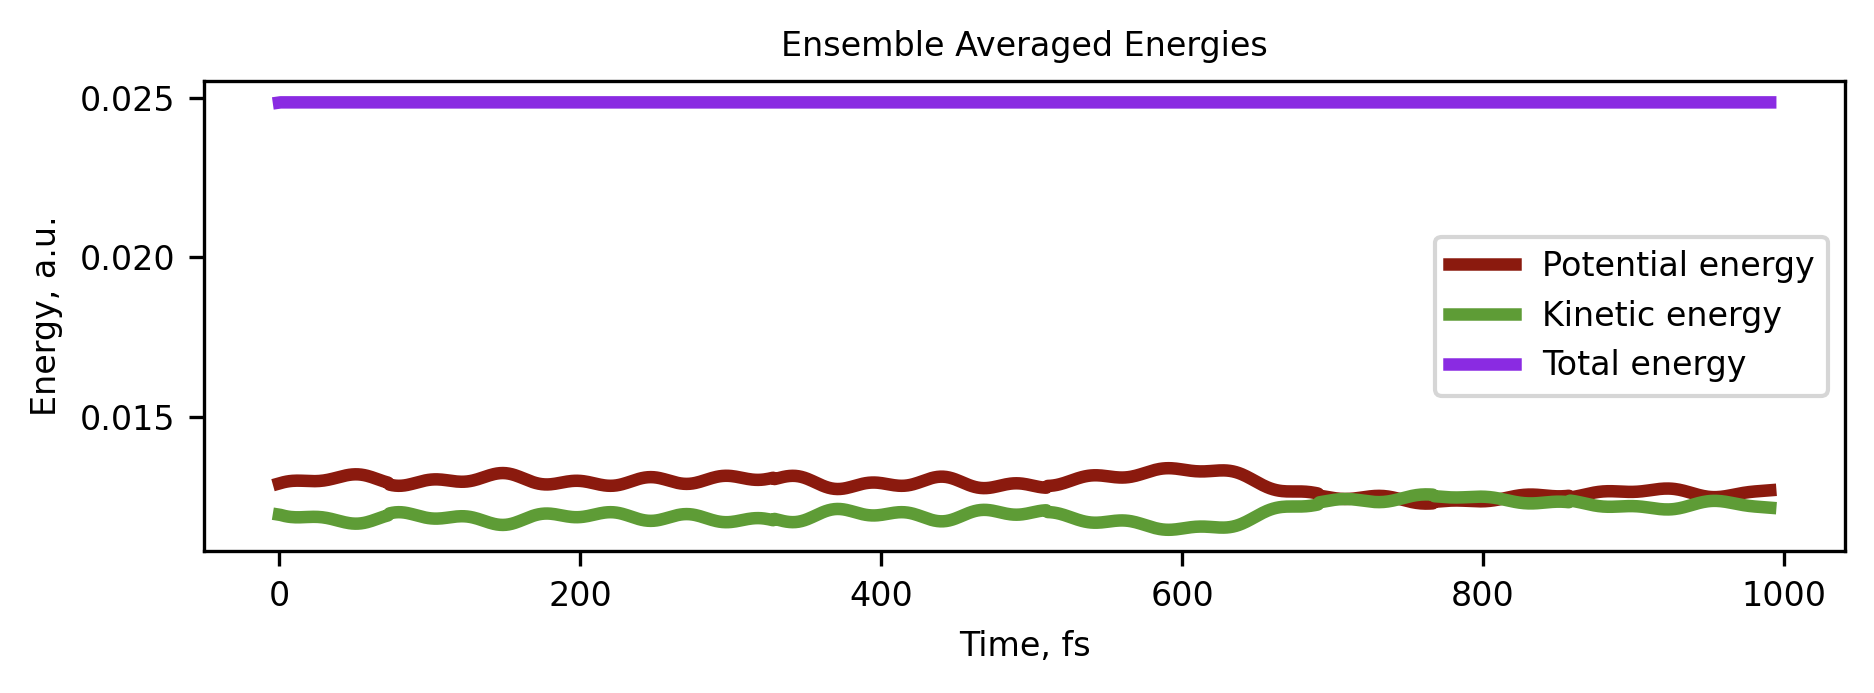

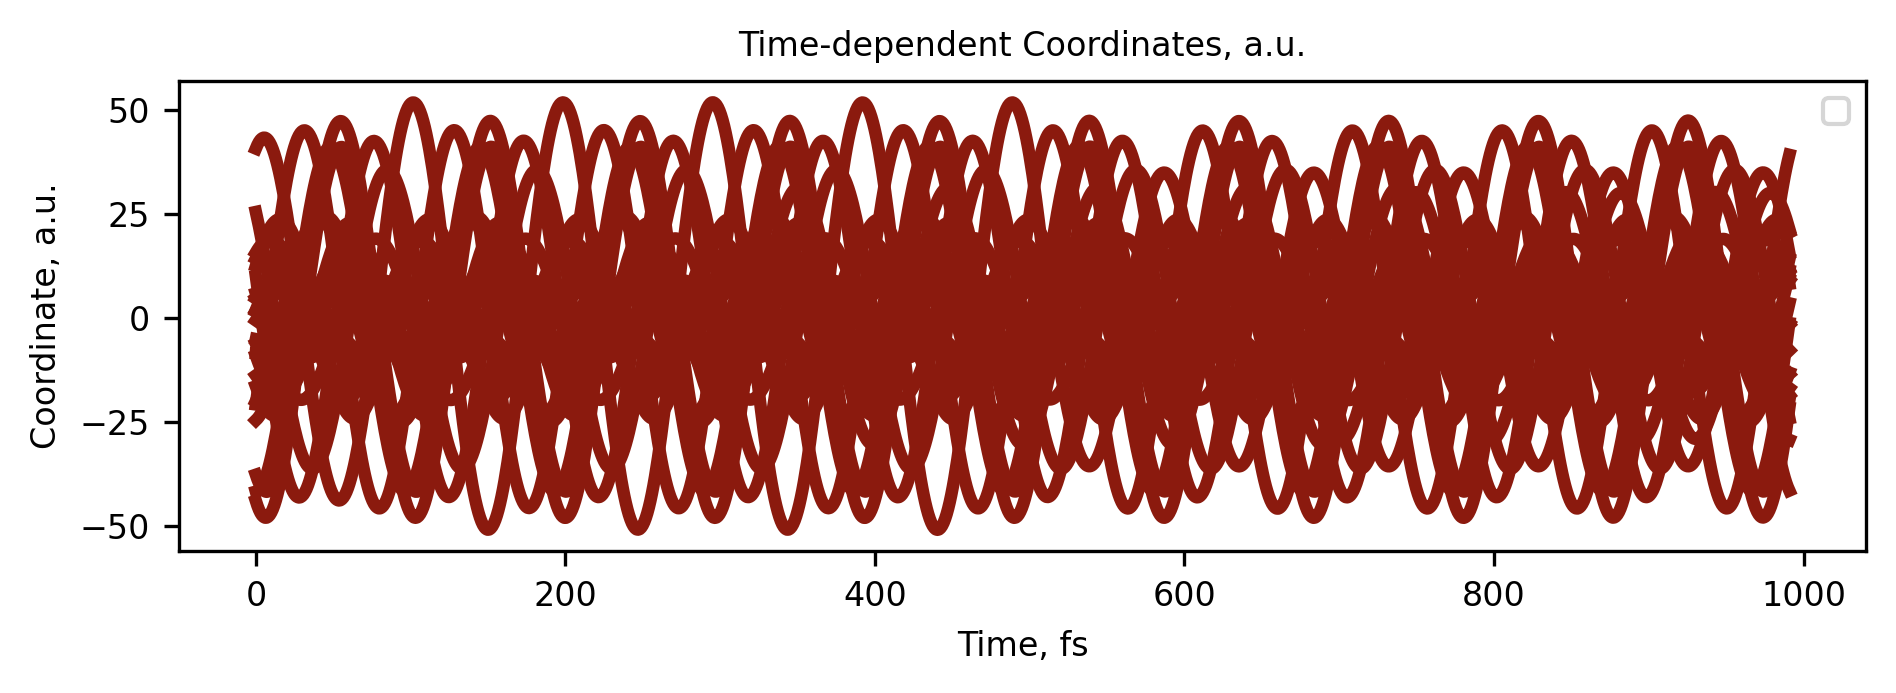

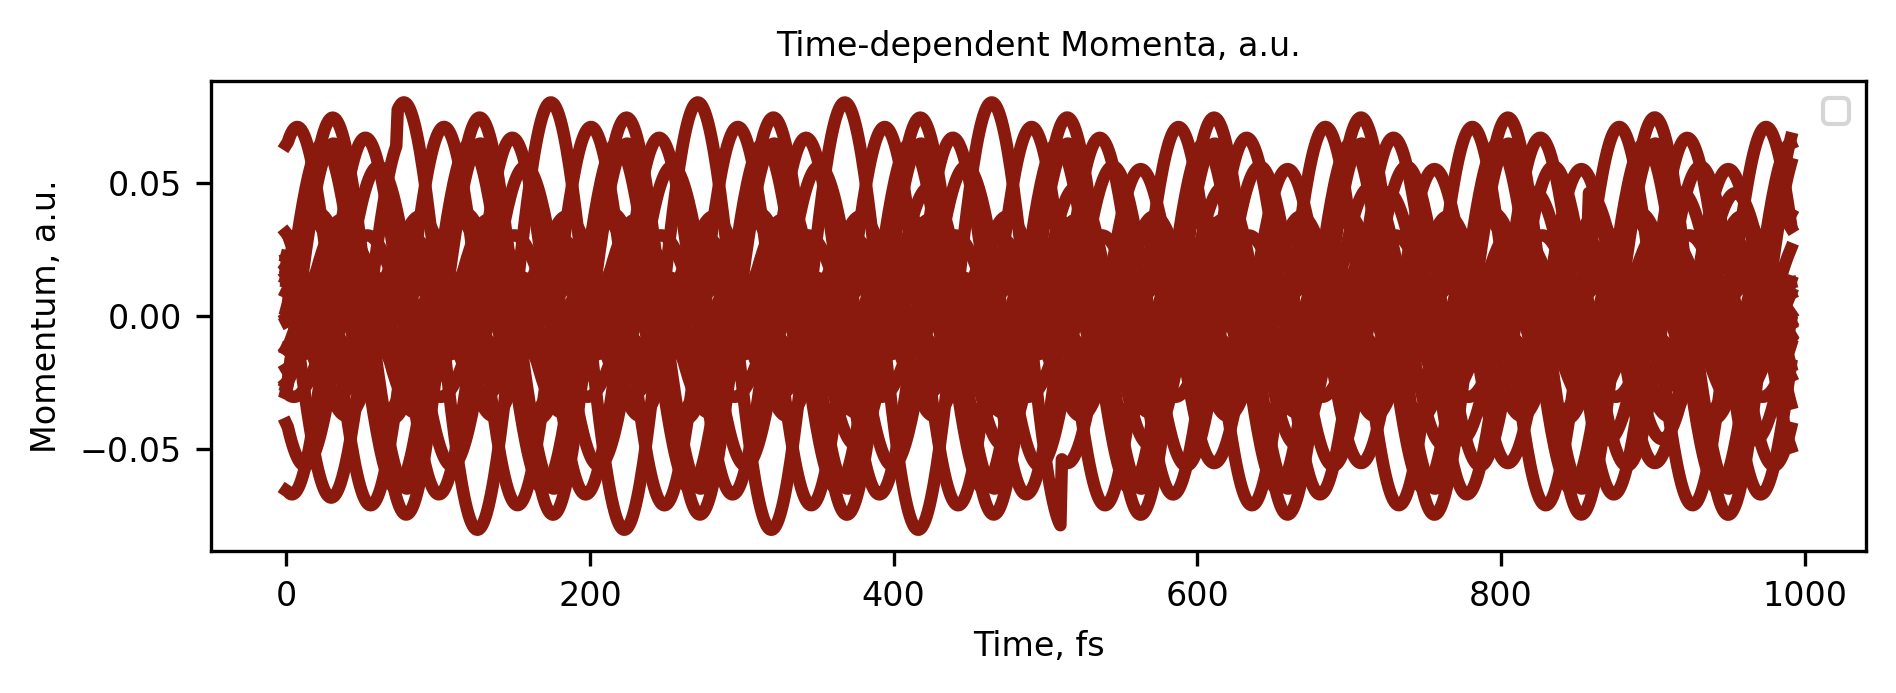

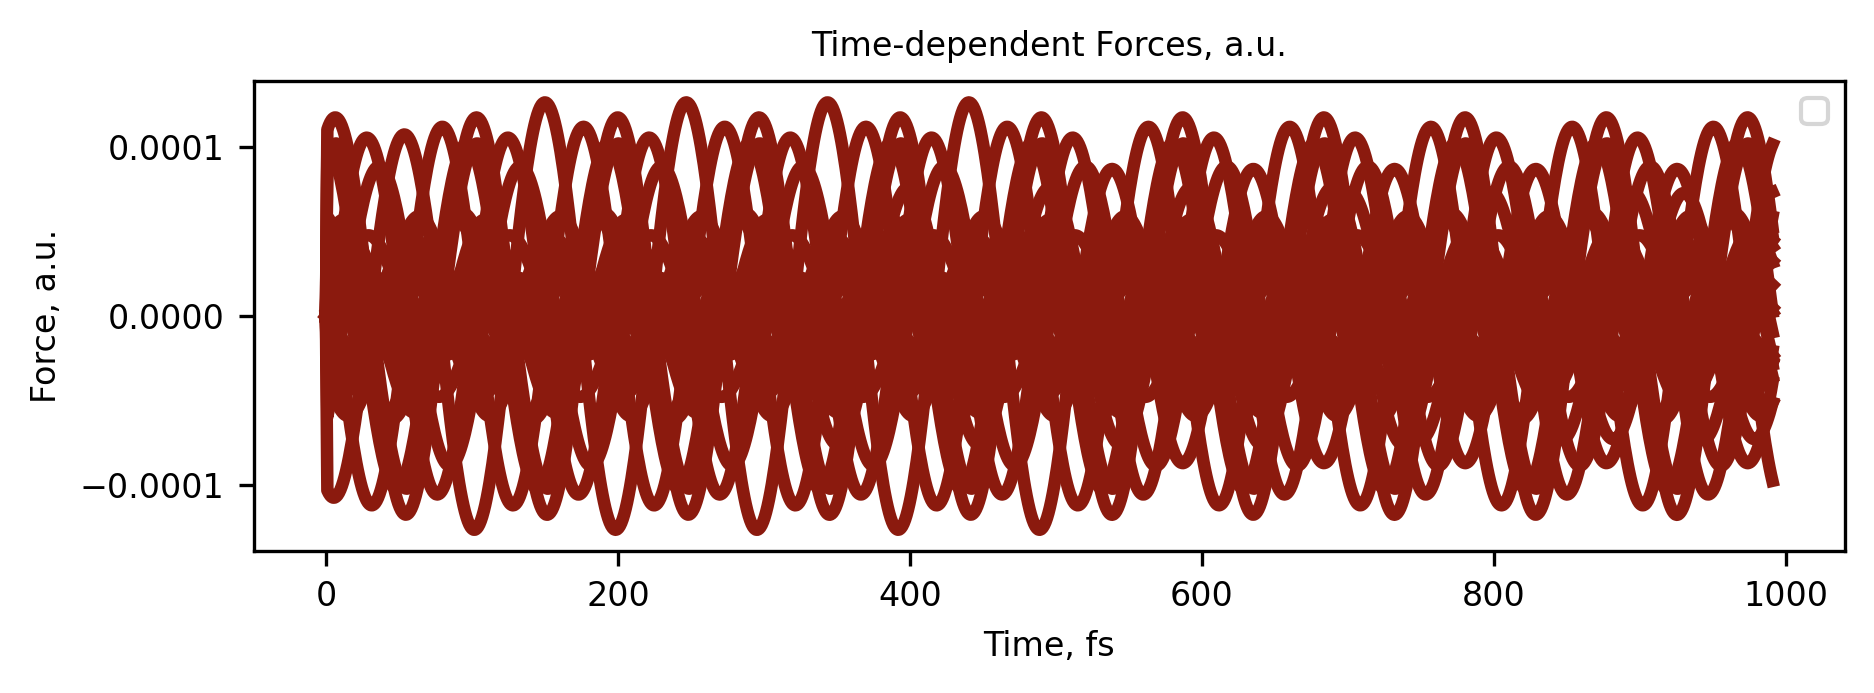

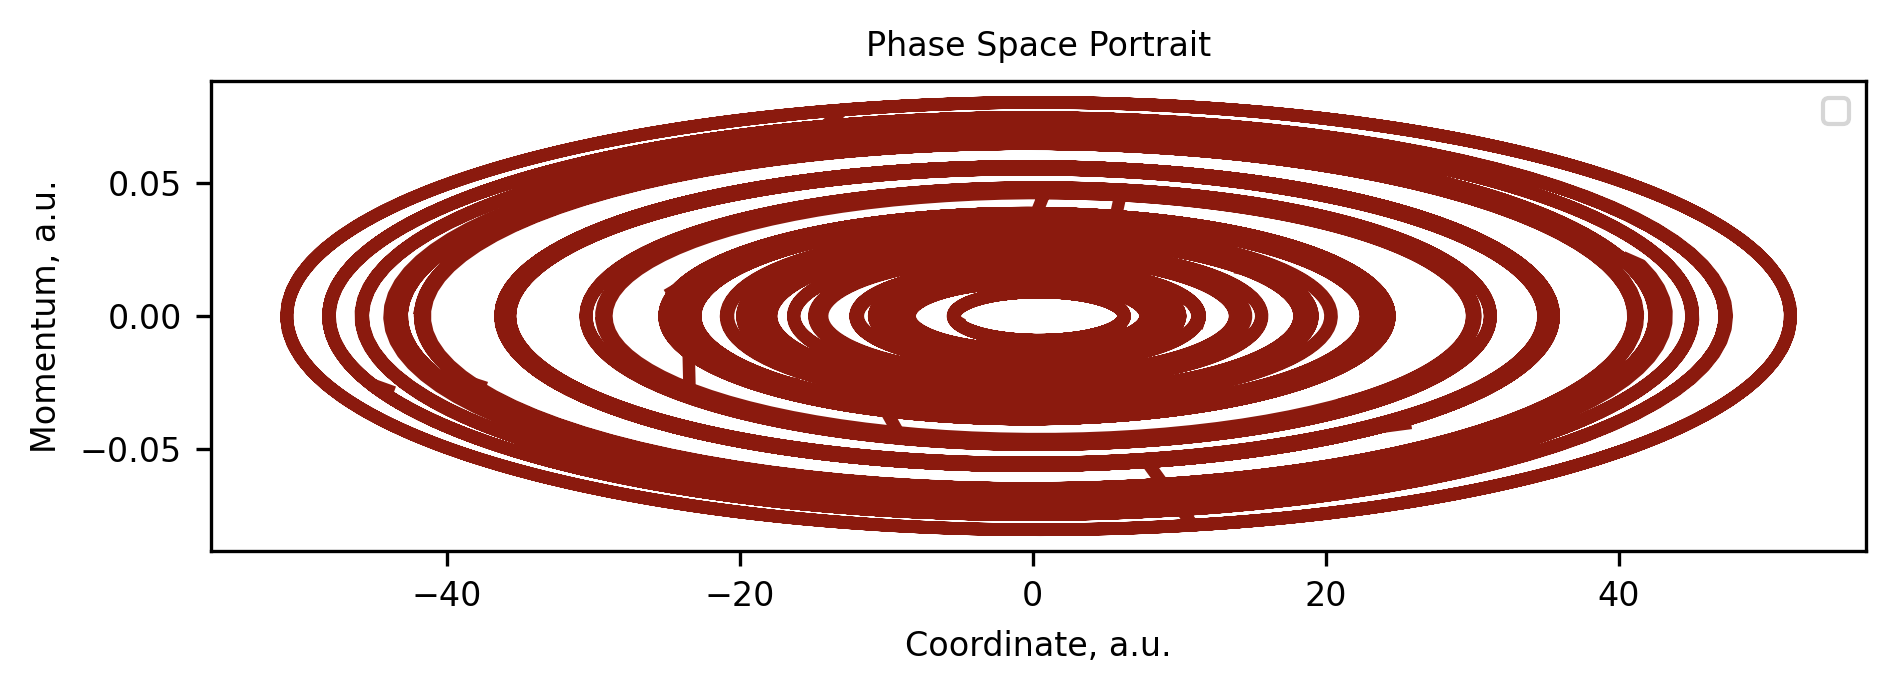

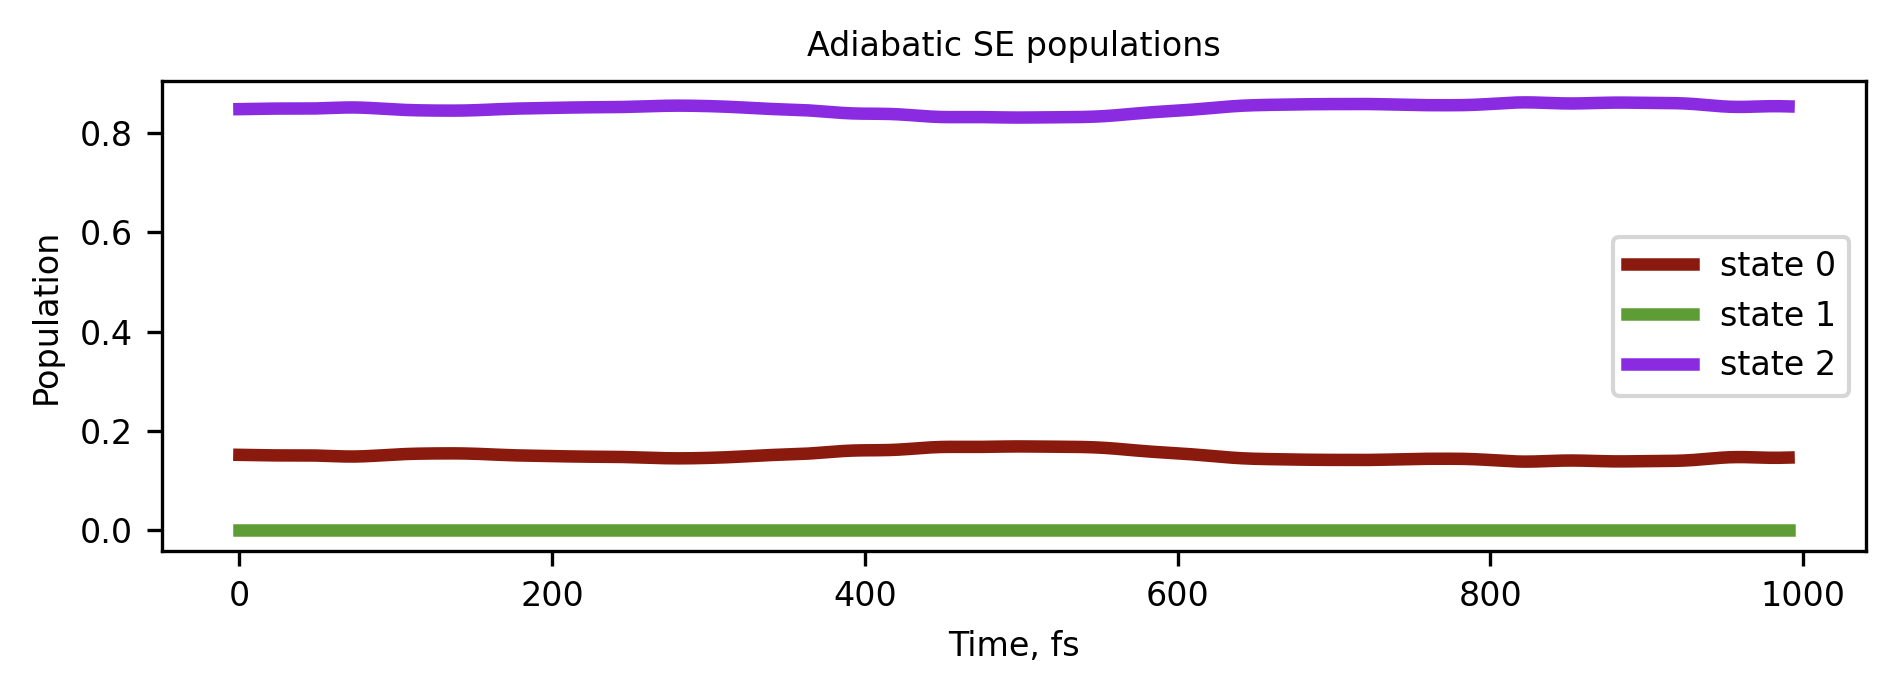

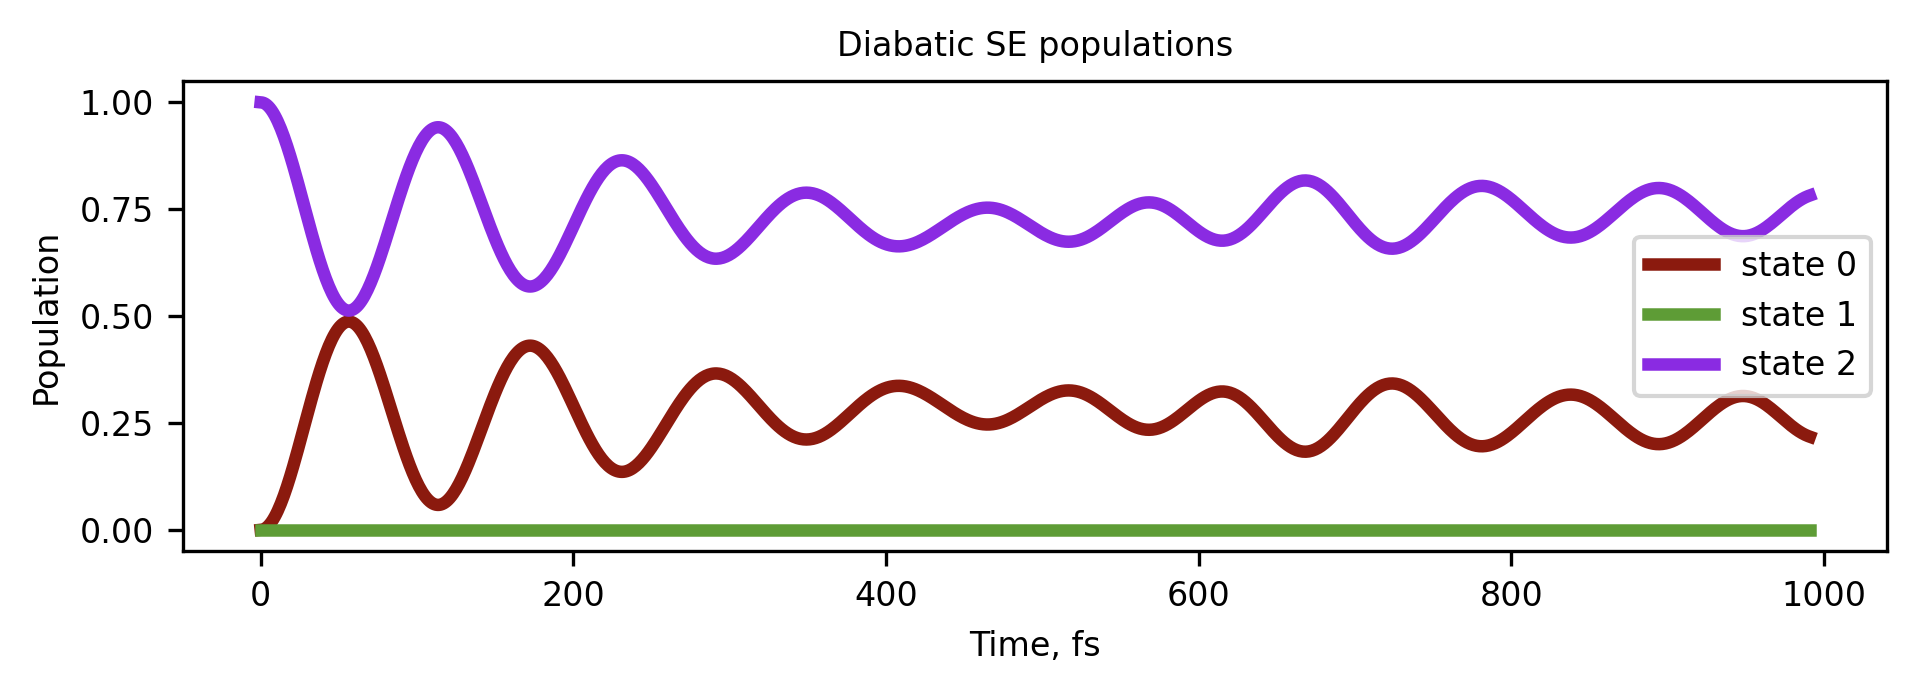

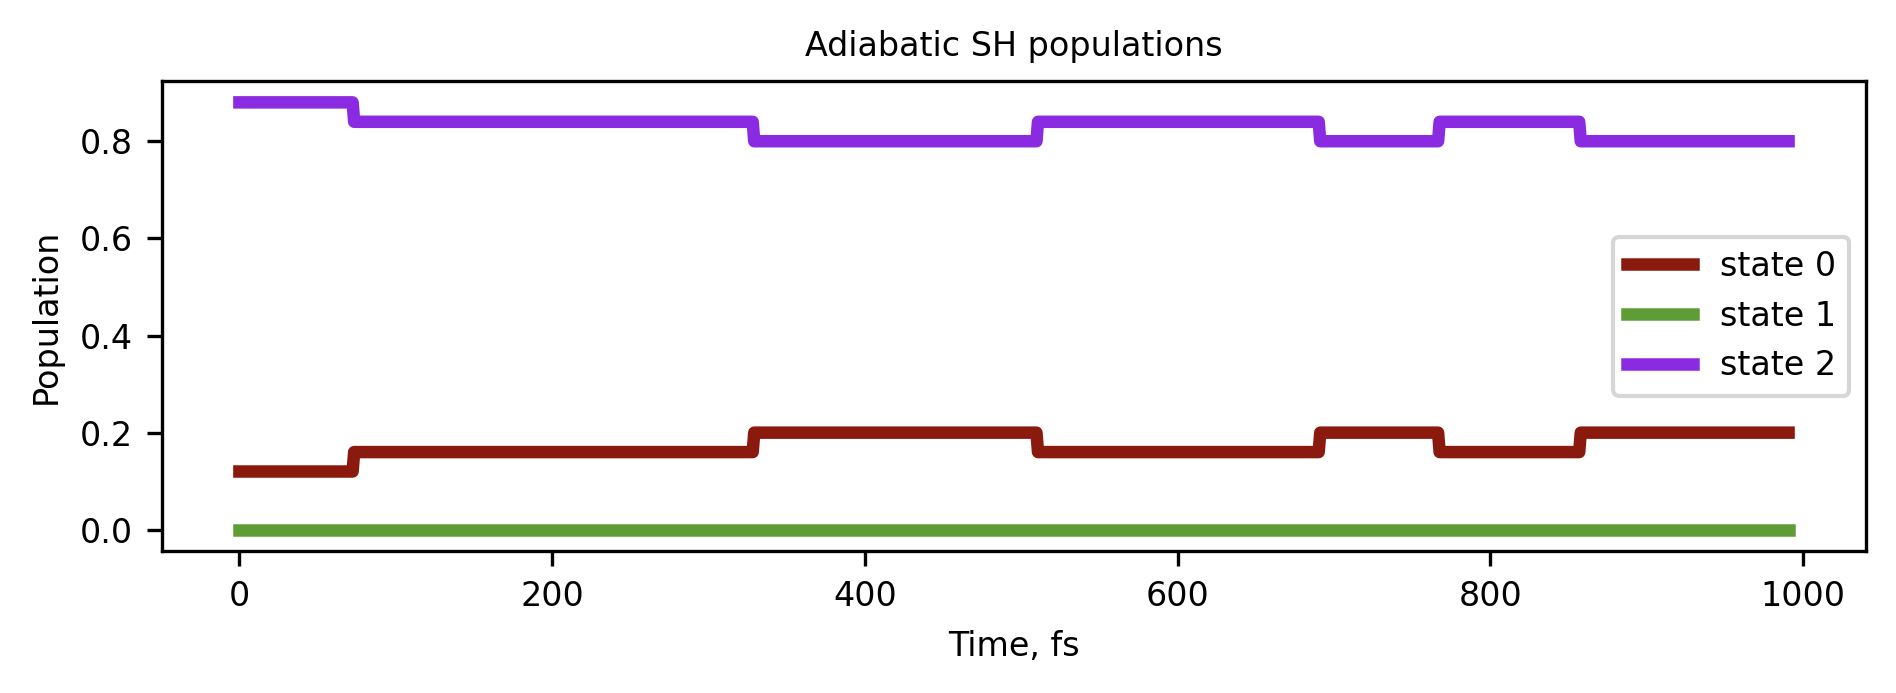

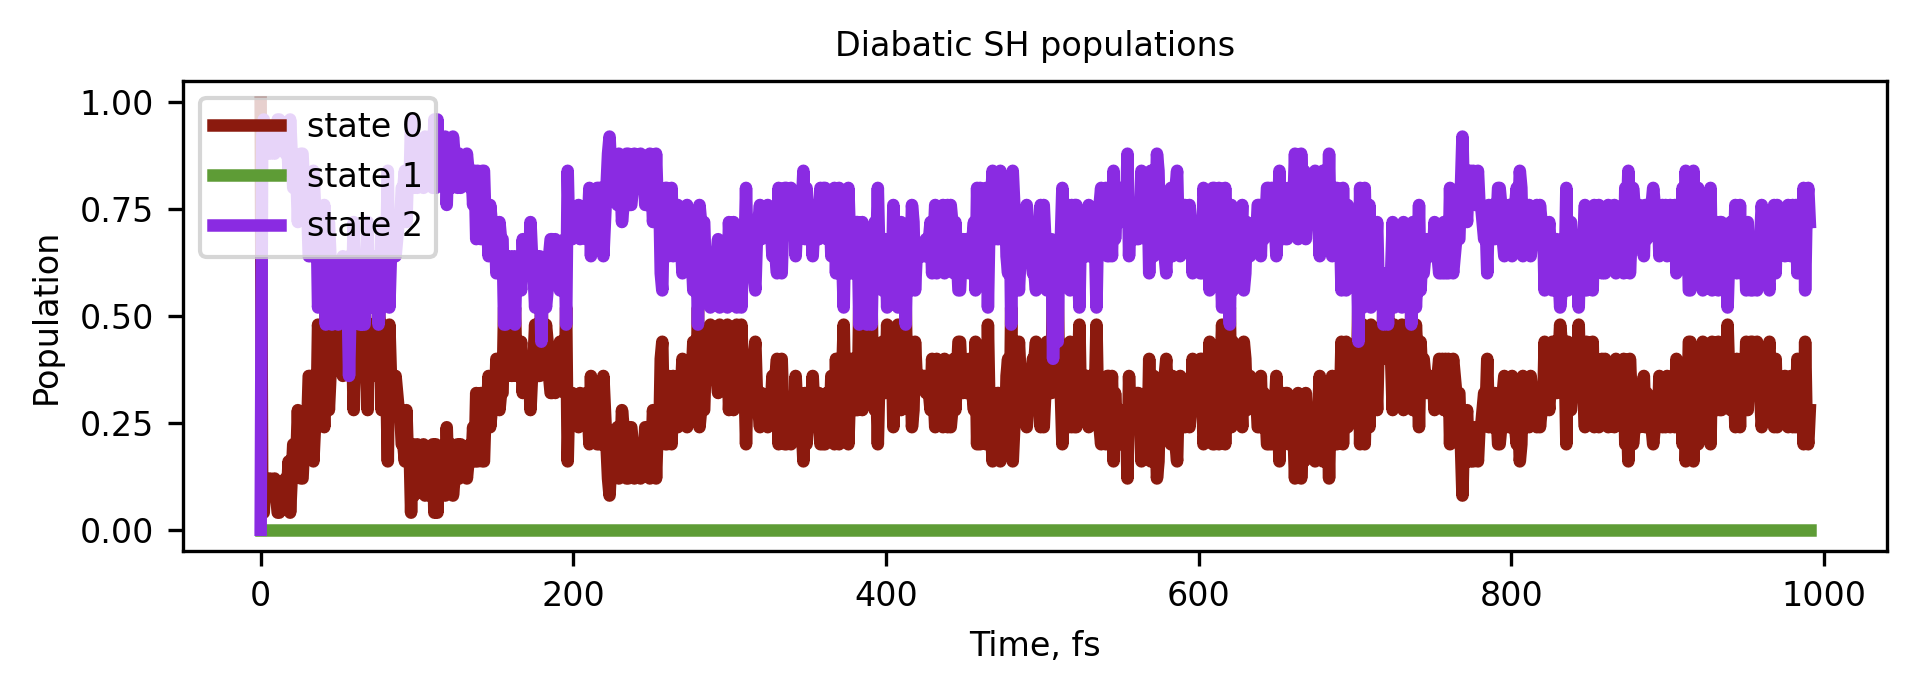

In [14]:
############################################################
### 5. Plot the results - preliminary plotting
############################################################

NTRAJ = dyn_general["ntraj"]
plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":list(range(NTRAJ)), "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi", "sh_pop_dia" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":0, "no_label":1
              }
tsh_dynamics_plot.plot_dynamics(plot_params)


# The block commented below will show the evolution of diabatiic and adiabatiic energy levels for the first trajectory.
# However, to plot it - you need to run the calculations using "mem_output_level":2, and defining "hvib_adi" and "hvib_dia"
# in the "properties_to_save"
"""
plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0], "which_adi_states":list(range(NSTATES)),
                "which_dia_states":list(range(NSTATES)),
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":[ "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham" ],
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":0, "no_label":1
              }
tsh_dynamics_plot.plot_dynamics(plot_params)
"""